# Burst Fitting example using BurstFit class

In [1]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, gauss_norm
from burstfit.io import BurstIO
import logging

In [2]:
logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)

## Get candidate cutout and preprocess

We will use `BurstData` class for this. It will crop the relevant time window. Dedisperse the data. Normalise the data to zero mean and unit standard deviation. Apply RFI masks (if any) and RFI filtering (if activated). 

In [3]:
fil_file = '../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil'

In [4]:
bd = BurstData(
    fp=fil_file,
    dm=565.3,
    tcand=2,
    width=64,
    snr=11.9,
    min_samp=256,
)

In [5]:
# We will mask channel numbers from 53 to 64 as they are 0. 
bd.prepare_data(mask_chans=[(53, 64)])

2021-10-20 18:16:10,944 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2021-10-20 18:16:11,012 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2021-10-20 18:16:11,013 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2021-10-20 18:16:11,066 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (128.00148285380777, 19.999437514831243)


Using <class 'str'>:
../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil

Here is the burst

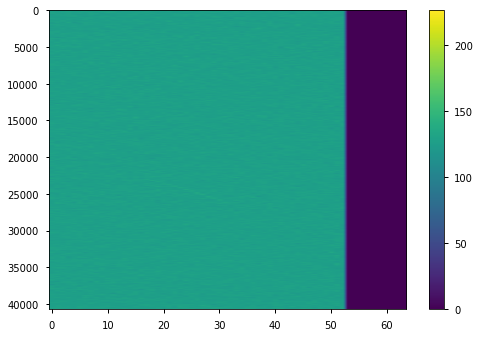

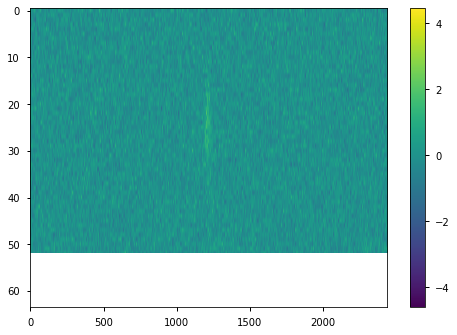

In [6]:
plot_me(bd.data)
plot_me(bd.sgram)

## Fitting using BurstFit

In `BurstFit`, the fitting procedure for each component is as follows: 
1. Fit the profile using `curve_fit` and a profile model
2. Find the spectra using profile fit parameters
3. Fit the spectra using `curve_fit` and spectra model 
4. Use the profile and spectra fit parameters as initial guess and fit the 2D spectrogram using `curve_fit` and spectrogram model 

Therefore, `BurstFit` requires three functions: profile function, spectra function and spectrogram function. It is assumed that spectrogram function will use profile and spectra functions to make the spectrogram.   

Use the `Model` class to make profile and spectra models. You can optionally give names of the input parameters. These parameter names are used by `BurstFit` to automatically set relevant fitting bounds and priors.  

In [7]:
# For pulse, we will use a gaussian convolved with an exponential model 
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)

Now we create a spectrogram model using `SgramModel` class, with the above two models and a spectrogram function (`sgram_fn_vec`)

In [8]:
sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
                        mask=bd.mask, clip_fac=bd.clip_fac)

Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 

In [9]:
bf = BurstFit(
    sgram_model=sgramModel,
    sgram=bd.sgram,
    width=bd.width,
    dm=bd.dm,
    foff=bd.foff,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask=bd.mask) 

In [10]:
# Some setting up before we do the fitting 
bf.validate()
bf.precalc()

The fit results are saved as a dictionary of dictionaries. The keys of the dictionary are component numbers. For each component, the dictionary consists of keys: `popt` and `perr`, representing the fitted parameters and their 1-sigma errors. 

So, let's fit one component:

### Profile Fit

2021-03-18 19:41:30,071 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-03-18 19:41:30,125 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-03-18 19:41:30,125 - initial_profilefit -burstfit.fit - INFO - S: 763.9470222396869 +- 76.47155802814272
2021-03-18 19:41:30,126 - initial_profilefit -burstfit.fit - INFO - mu_t: 1202.832588161036 +- 3.3843576775928397
2021-03-18 19:41:30,126 - initial_profilefit -burstfit.fit - INFO - sigma_t: 11.487928835362144 +- 2.863860070777841
2021-03-18 19:41:30,127 - initial_profilefit -burstfit.fit - INFO - tau: 15.684895946500633 +- 6.35034474880263


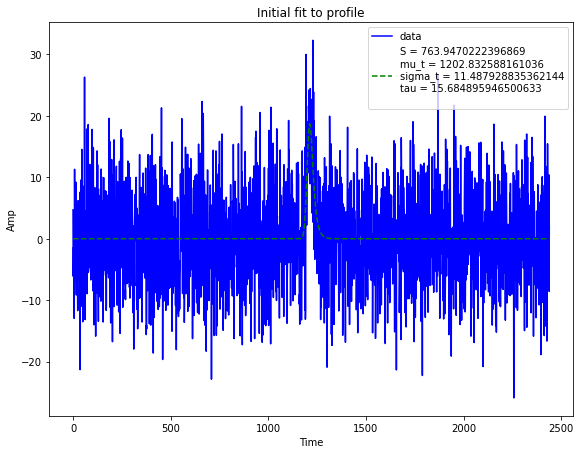

In [11]:
plot = True
bf.initial_profilefit(plot=plot)

### Spectra Fit

In [12]:
bf.make_spectra()

2021-03-18 19:41:30,472 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.


2021-03-18 19:41:30,546 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-03-18 19:41:30,552 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-03-18 19:41:30,553 - initial_spectrafit -burstfit.fit - INFO - mu_f: 24.478044459914074 +- 0.40858355670038715
2021-03-18 19:41:30,553 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 5.876907075384988 +- 0.3336071378032658


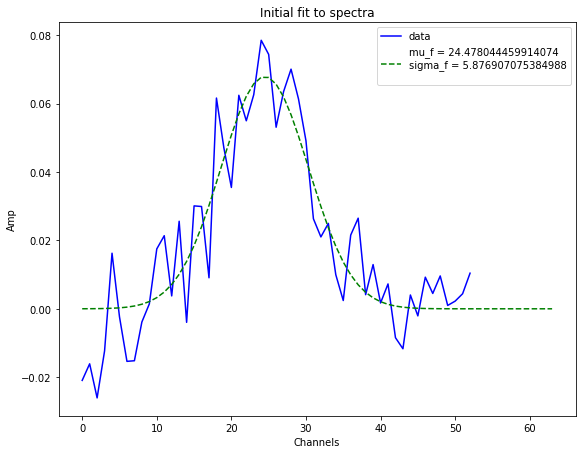

In [13]:
bf.initial_spectrafit(plot=plot)

Let's look at the profile and spectra fit parameters we just obtained 
(these were also printed in the logs above)

In [14]:
bf.profile_params

{1: {'popt': [763.9470222396869,
   1202.832588161036,
   11.487928835362144,
   15.684895946500633],
  'perr': array([76.47155803,  3.38435768,  2.86386007,  6.35034475])}}

In [15]:
bf.spectra_params

{1: {'popt': [24.478044459914074, 5.876907075384988],
  'perr': array([0.40858356, 0.33360714])}}

Now the above parameters will be used as initial guess to do sgram fitting. 

### Spectrogram Fit

2021-03-18 19:41:30,981 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-03-18 19:41:30,981 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [24.478044459914074, 5.876907075384988, 763.9470222396869, 1202.832588161036, 11.487928835362144, 15.684895946500633, 565.3]
2021-03-18 19:41:31,523 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-03-18 19:41:31,523 - sgram_fit -burstfit.fit - INFO - mu_f: 24.975849003327195 +- 0.3914311686459791
2021-03-18 19:41:31,524 - sgram_fit -burstfit.fit - INFO - sigma_f: 6.166294966919394 +- 0.3834043551301487
2021-03-18 19:41:31,524 - sgram_fit -burstfit.fit - INFO - S: 731.2832079635614 +- 48.013029647860286
2021-03-18 19:41:31,524 - sgram_fit -burstfit.fit - INFO - mu_t: 1207.2991214508688 +- 4.213243536228096
2021-03-18 19:41:31,525 - sgram_fit -burstfit.fit - INFO - sigma_t: 11.259609732524533 +- 1.5688742150501045
2021-03-18 19:41:31,525 - sgram_fit -burstfit.fit - INFO - tau: 6.

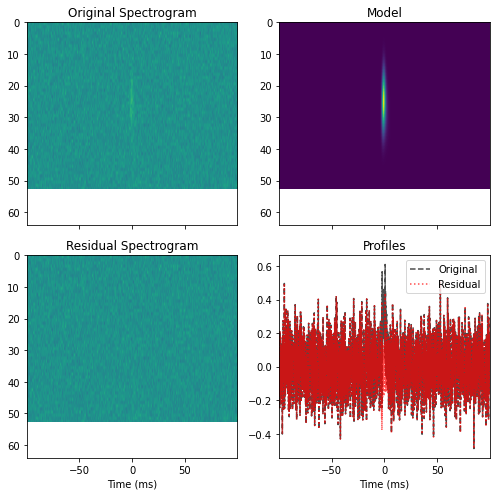

2021-03-18 19:41:32,291 - model -burstfit.fit - INFO - Making model.
2021-03-18 19:41:32,292 - model -burstfit.fit - INFO - Found 1 components.


In [16]:
bf.sgram_fit(plot=plot)

We can see the reduced chi square value of our sgram_fit too

In [17]:
bf.calc_redchisq()

2021-03-18 19:41:32,305 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-03-18 19:41:32,306 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-03-18 19:41:32,308 - model -burstfit.fit - INFO - Making model.
2021-03-18 19:41:32,308 - model -burstfit.fit - INFO - Found 1 components.
2021-03-18 19:41:32,320 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 0.9957156205218006


0.9957156205218006

The fit parameters can be accessed using bf.sgram_params. It shows only one component as we only did one component fitting.

In [18]:
bf.sgram_params

{1: {'popt': [24.975849003327195,
   6.166294966919394,
   731.2832079635614,
   1207.2991214508688,
   11.259609732524533,
   6.132069921186363,
   564.3361968307069],
  'perr': array([ 0.39143117,  0.38340436, 48.01302965,  4.21324354,  1.56887422,
          1.62351806,  0.52390598])}}

## fitcycle()

All the above steps have also been wrapped with fitcycle() 

2021-03-18 19:41:32,433 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2021-03-18 19:41:32,434 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-03-18 19:41:32,468 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2021-03-18 19:41:32,468 - initial_profilefit -burstfit.fit - INFO - S: 763.9470222396869 +- 76.47155802814272
2021-03-18 19:41:32,469 - initial_profilefit -burstfit.fit - INFO - mu_t: 1202.832588161036 +- 3.3843576775928397
2021-03-18 19:41:32,471 - initial_profilefit -burstfit.fit - INFO - sigma_t: 11.487928835362144 +- 2.863860070777841
2021-03-18 19:41:32,472 - initial_profilefit -burstfit.fit - INFO - tau: 15.684895946500633 +- 6.35034474880263


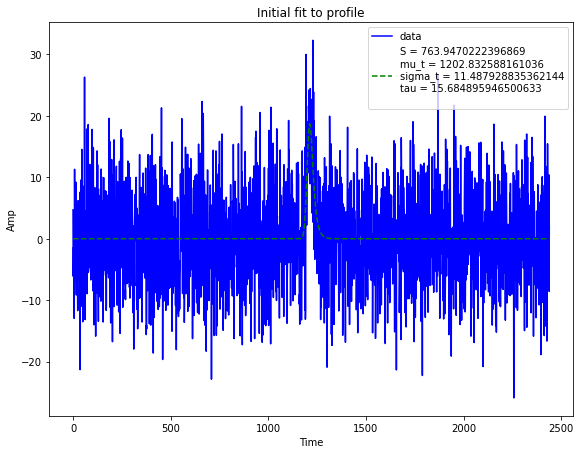

2021-03-18 19:41:32,914 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-03-18 19:41:32,915 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-03-18 19:41:32,921 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-03-18 19:41:32,921 - initial_spectrafit -burstfit.fit - INFO - mu_f: 24.478044459914074 +- 0.40858355670038715
2021-03-18 19:41:32,922 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 5.876907075384988 +- 0.3336071378032658


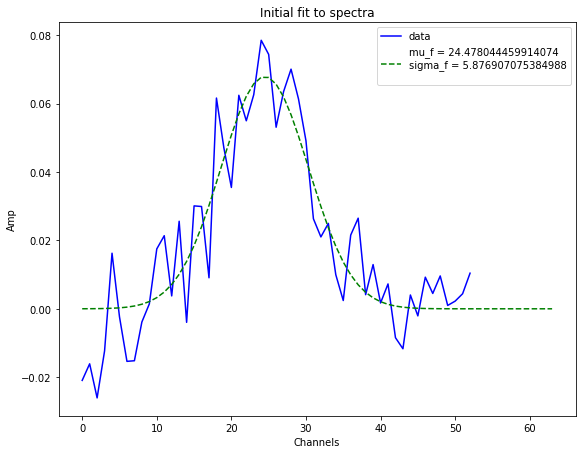

2021-03-18 19:41:33,358 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-03-18 19:41:33,358 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [24.478044459914074, 5.876907075384988, 763.9470222396869, 1202.832588161036, 11.487928835362144, 15.684895946500633, 565.3]
2021-03-18 19:41:34,002 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-03-18 19:41:34,003 - sgram_fit -burstfit.fit - INFO - mu_f: 24.975849003327195 +- 0.3914311686459791
2021-03-18 19:41:34,004 - sgram_fit -burstfit.fit - INFO - sigma_f: 6.166294966919394 +- 0.3834043551301487
2021-03-18 19:41:34,004 - sgram_fit -burstfit.fit - INFO - S: 731.2832079635614 +- 48.013029647860286
2021-03-18 19:41:34,004 - sgram_fit -burstfit.fit - INFO - mu_t: 1207.2991214508688 +- 4.213243536228096
2021-03-18 19:41:34,005 - sgram_fit -burstfit.fit - INFO - sigma_t: 11.259609732524533 +- 1.5688742150501045
2021-03-18 19:41:34,005 - sgram_fit -burstfit.fit - INFO - tau: 6.

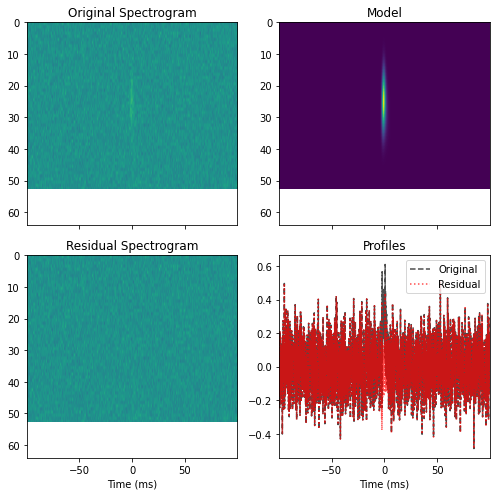

2021-03-18 19:41:34,772 - model -burstfit.fit - INFO - Making model.
2021-03-18 19:41:34,772 - model -burstfit.fit - INFO - Found 1 components.
2021-03-18 19:41:34,782 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-03-18 19:41:34,782 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-03-18 19:41:34,784 - model -burstfit.fit - INFO - Making model.
2021-03-18 19:41:34,785 - model -burstfit.fit - INFO - Found 1 components.
2021-03-18 19:41:34,796 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 0.9957156205218006


In [19]:
bf.fitcycle(plot=True)

## fitall()

But `fitcycle()` only fits for one component. `BurstFit` can automatically fit for multiple components as well. For that we will use `fitall()`

Here it calls `fitcycle()` to fit for a component and then compares the ON-pulse residual with the OFF pulse regions (both left and right). If the distributions are similar then fitting is terminated. If the distributions aren't similar, then it tries to fit for another component. In the end, it will fit for all the components together. 

2021-03-18 19:41:34,801 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-03-18 19:41:34,802 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-03-18 19:41:34,811 - tests -root - INFO - P values: T-test (0.60679), Kruskal (0.70429), KS (0.87426), F-test (0.61511)
2021-03-18 19:41:34,811 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2021-03-18 19:41:34,819 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00044)
2021-03-18 19:41:34,819 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2021-03-18 19:41:34,828 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00001), F-test (0.00015)
2021-03-18 19:41:34,828 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2021-03-18 19:41:34,829 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-03-18 19:41:34,862 - initial_profilefi

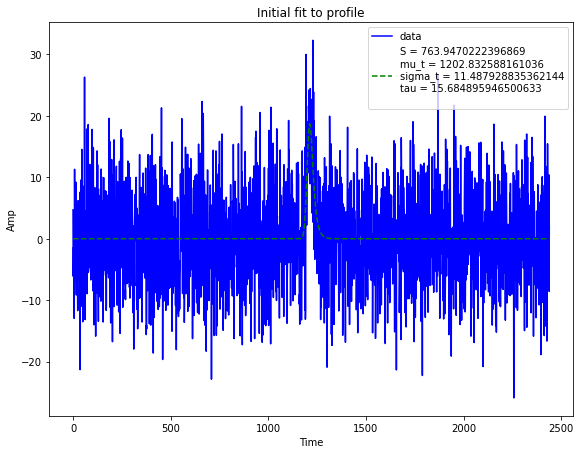

2021-03-18 19:41:35,203 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2021-03-18 19:41:35,204 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2021-03-18 19:41:35,210 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2021-03-18 19:41:35,210 - initial_spectrafit -burstfit.fit - INFO - mu_f: 24.478044459914074 +- 0.40858355670038715
2021-03-18 19:41:35,211 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 5.876907075384988 +- 0.3336071378032658


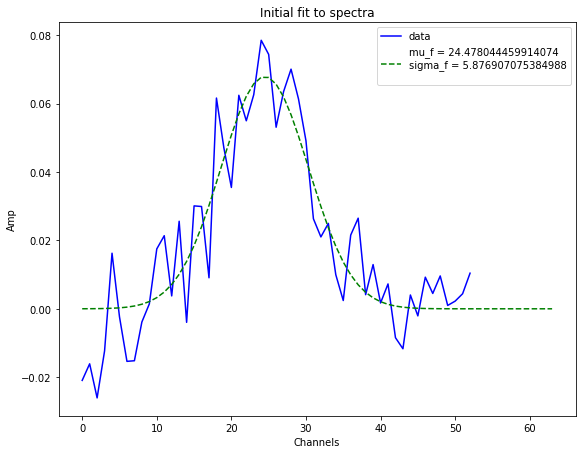

2021-03-18 19:41:35,456 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2021-03-18 19:41:35,456 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [24.478044459914074, 5.876907075384988, 763.9470222396869, 1202.832588161036, 11.487928835362144, 15.684895946500633, 565.3]
2021-03-18 19:41:35,995 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2021-03-18 19:41:35,995 - sgram_fit -burstfit.fit - INFO - mu_f: 24.975849003327195 +- 0.3914311686459791
2021-03-18 19:41:35,996 - sgram_fit -burstfit.fit - INFO - sigma_f: 6.166294966919394 +- 0.3834043551301487
2021-03-18 19:41:35,996 - sgram_fit -burstfit.fit - INFO - S: 731.2832079635614 +- 48.013029647860286
2021-03-18 19:41:35,996 - sgram_fit -burstfit.fit - INFO - mu_t: 1207.2991214508688 +- 4.213243536228096
2021-03-18 19:41:35,997 - sgram_fit -burstfit.fit - INFO - sigma_t: 11.259609732524533 +- 1.5688742150501045
2021-03-18 19:41:35,997 - sgram_fit -burstfit.fit - INFO - tau: 6.

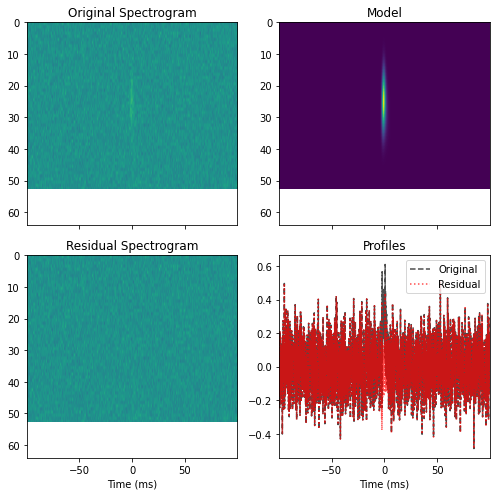

2021-03-18 19:41:36,764 - model -burstfit.fit - INFO - Making model.
2021-03-18 19:41:36,765 - model -burstfit.fit - INFO - Found 1 components.
2021-03-18 19:41:36,774 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2021-03-18 19:41:36,775 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2021-03-18 19:41:36,777 - model -burstfit.fit - INFO - Making model.
2021-03-18 19:41:36,777 - model -burstfit.fit - INFO - Found 1 components.
2021-03-18 19:41:36,789 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 0.9957156205218006
2021-03-18 19:41:36,790 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-03-18 19:41:36,790 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-03-18 19:41:36,799 - tests -root - INFO - P values: T-test (0.60679), Kruskal (0.70429), KS (0.87426), F-test (0.61511)
2021-03-18 19:41:36,799 - run

In [20]:
bf.fitall(plot=True)

The logging above shows the results of the statistical tests performed to compare the ON pulse residual with OFF pulse regions. Both the Left and Right off pulse regions were found to be statistically similar to ON pulse residual, and therefore the fitting was terminated. 

Again, the parameters can be accessed using `sgram_params`. The final parameters are saved in "all" key. This is useful in case of multiple components. In that case, individual component number will show the fit results for inidividual component, while "all" will give the result of fitting all the components together. In this case, we just had one component, so `fit_all_components` wasn't used, and therefore key "1" and "all" have same parameters. 

In [21]:
bf.sgram_params['all']

{1: {'popt': [24.975849003327195,
   6.166294966919394,
   731.2832079635614,
   1207.2991214508688,
   11.259609732524533,
   6.132069921186363,
   564.3361968307069],
  'perr': array([ 0.39143117,  0.38340436, 48.01302965,  4.21324354,  1.56887422,
          1.62351806,  0.52390598])}}

## Plotting Results 

We can also plot the model, sgram and residuals

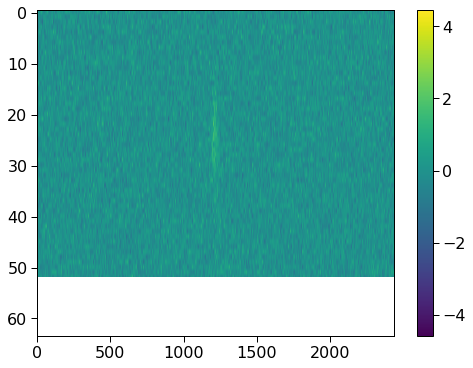

In [22]:
plot_me(bf.sgram)

2021-03-18 19:41:37,234 - model -burstfit.fit - INFO - Making model.
2021-03-18 19:41:37,235 - model -burstfit.fit - INFO - Found 1 components.


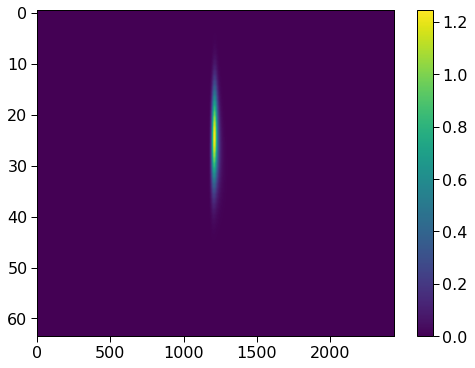

In [23]:
plot_me(bf.model)

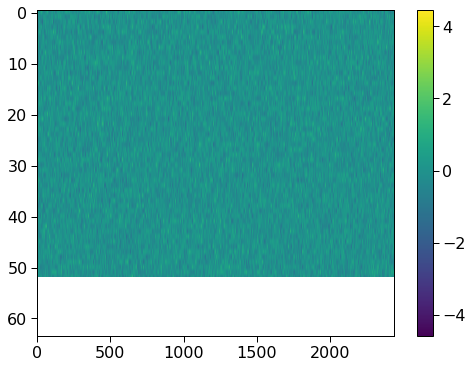

In [24]:
plot_me(bf.residual)

There are two ways of visualising plotting results using multi-panel plots. Using `plot_2d_fit` and `plot_fit_results`

In [25]:
from burstfit.utils.plotter import plot_2d_fit, plot_fit_results

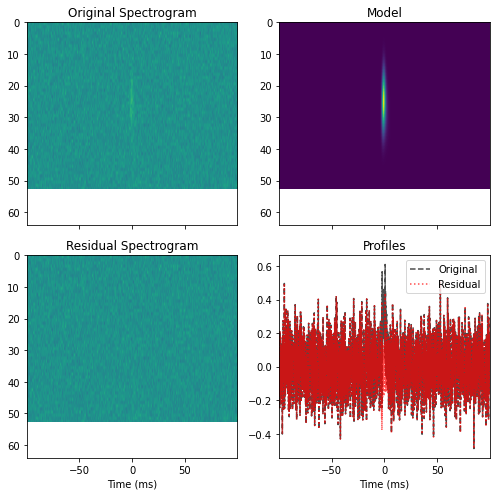

In [26]:
plot_2d_fit(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
            bf.tsamp, show=True, save=False)

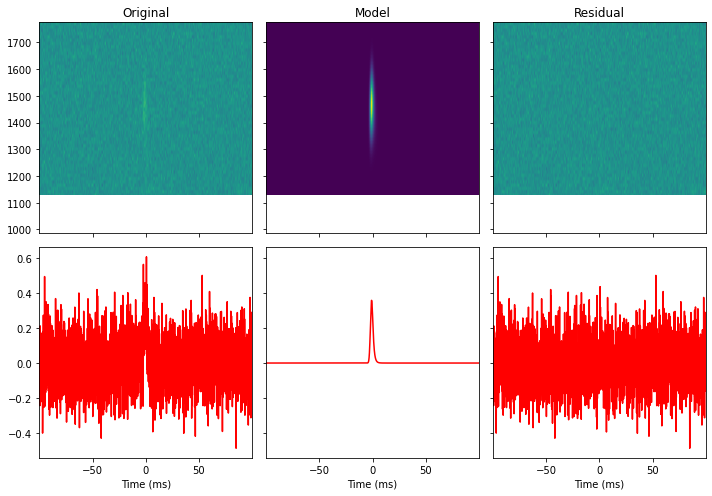

In [27]:
plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
                 bf.tsamp, bf.fch1, bf.foff, show=True, save=False)

Now, to save the fitting results we can use `BurstIO` class. See this notebook.  